In [1]:
import numpy as np
import sklearn as sk
from sklearn import ensemble
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
import tensorflow.keras as tfk
import matplotlib.pyplot as plt
from corner import corner

In [ ]:
import tensorflow.keras as tfk

This notebook will guide you through the process of training a Neural Network on synthetic transmission spectra of exoplanets to retrieve their temperature; H$_2$O, HCN and NH$_3$ abundances; and cloud opacities. 

Data are from Márquez-Neila et al., 2018. Methods adapted from Cobb et al., 2019.

### Neural Networks

A Neural Network is essentially just a succession of linear transformations followed by non-linear activations.
The Universal Approximation Theorem states that such a network can approximate any function, given that it is continuous. It however doesn't say how to build it.


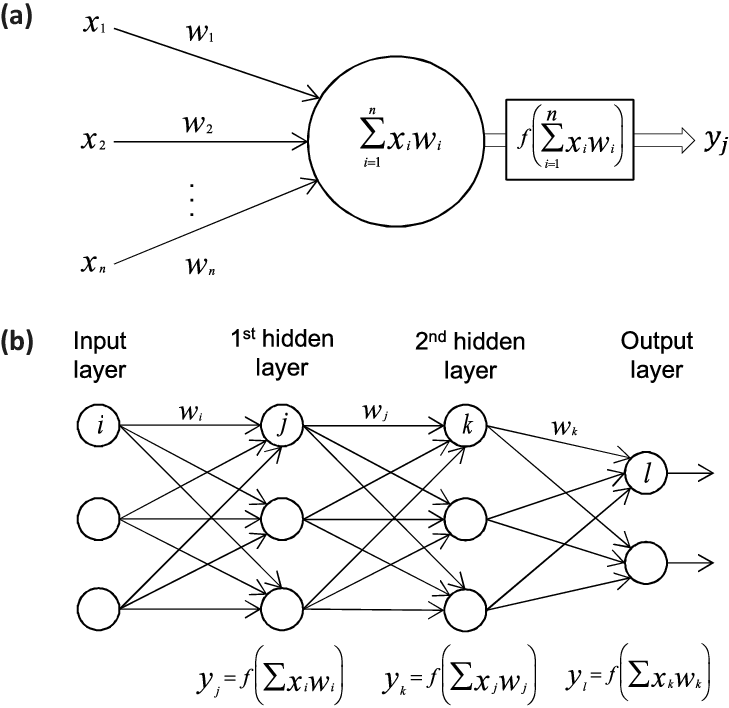

### Load the data

```Train``` contains the training set of 80,000 synthetic spectra.

```Test``` contains 20,000 synthetic spectra to evaluate the neural network once trained.

```WASP12b``` contains the HST/WFC3 spectrum of WASP-12b, taken from Kreidberg et al., 2015.

In [2]:
Train   = np.load('Data/training.npy')
Test    = np.load('Data/testing.npy')
WASP12b = np.loadtxt('Data/WASP-12b_Kreidberg2015.dat')*100  # Factor 100 to convert it to %

### Define the metadata of the datasets.

There are 13 features, which are the 13 wavelength bins in the spectra.

The number of targets, or parameters, is 5. 

In [3]:
num_features = 13
num_targets  = 5
names        = ['T', r'H$_2$O', 'HCN', r'NH$_3$', r'$\kappa$']

### Split the training and testing datasets into features and targets, and normalize the data

In [4]:
X_train = Train[:, :num_features]
Y_train = Train[:, num_features:]

X_test = Test[:, :num_features]
Y_test = Test[:, num_features:]


norm_x, norm_y = True, True

if norm_x:
    X_scaler = StandardScaler()
    X_scaler.fit(X_train)
    
    X_train = X_scaler.transform(X_train)
    X_test  = X_scaler.transform(X_test)

if norm_y:
    Y_scaler = StandardScaler()
    Y_scaler.fit(Y_train)
    
    Y_train = Y_scaler.transform(Y_train)

### Create the Neural Network

```architecture``` is a list with the number of neurons per layer.

```activation``` is a non linear function. ReLU stands for Rectified Linear Unit, it returns $f(x<0) = 0$ and $f(x>0)=x$.

```tfk.layers.Input``` defines the shape of the inputs.

```tfk.layers.Dense``` defines the type of layer to use, in this case Dense (meaning all neurons in one layer are connected to all neurons in the next one).

```dropout_rate``` is the fraction of weights to randomly turn off each time.

In [5]:
architecture = [64, 64, 64, 64]
dropout_rate = 0.1
activation   = 'relu'

In [ ]:
inputs = tfk.layers.Input(shape=(num_features,))

x = tfk.layers.Dense(architecture[0], activation=activation)(inputs)
x = tfk.layers.Dropout(dropout_rate)(x, training=True)
        
for i in architecture[1:]:
    x = tfk.layers.Dense(i, activation=activation)(x)
    x = tfk.layers.Dropout(dropout_rate)(x, training=True)
            
outputs = tfk.layers.Dense(num_targets)(x)

model = tfk.Model(inputs, outputs)

model.compile(optimizer='adam', loss='mse')

### Train the neural network

In [ ]:
history = model.fit(X_train, Y_train, epochs=100,  batch_size=512, verbose=1, validation_split=.12, shuffle=True)
model.summary()

### Plot the learning process of the Neural Network

In [ ]:
plt.figure(figsize=(8,6))
plt.plot(history.history['loss'],label='train')
plt.plot(history.history['val_loss'],label='val')
plt.ylim([0.002,0.006])
plt.legend()

### Evaluate the Neural Network

Make predictions on the test dataset and plot them against the true values.

In [ ]:
pred = model.predict(X_test)

if norm_y:
    pred   = Y_scaler.inverse_transform(pred)

R2 = [sk.metrics.r2_score(Y_test[:,i], pred[:,i]) for i in range(len(Y_test[0]))]


fig, axs = plt.subplots( 2, 3, figsize=(18,12) )

c=0
for i in range(2):
    for j in range(3):
        if c==num_targets:
            break
            
        axs[i,j].scatter( Y_test[:,c], pred[:,c], alpha=.03, label = r'$R^2 = $' + str( round(R2[c], 2) ) )
        axs[i,j].plot( [-13,3000], [-13,3000], 'r--' )
        
        axs[i,j].set_xlim( [min(Y_test[:,c]), max(Y_test[:,c])] )
        axs[i,j].set_ylim( [min(Y_test[:,c]), max(Y_test[:,c])] )
        
        axs[i,j].set_xlabel('True ' + names[c])
        axs[i,j].set_ylabel('Predicted ' + names[c])
        axs[i,j].grid(True)
        axs[i,j].legend()
        c+=1

axs[1,2].remove()
plt.suptitle( r'$R^2=$ ' + str( round( np.mean(R2), 2 ) ) )
plt.show()

### WASP-12b retrieval

Draw 100 samples of WASP-12b's spectrum scattered according to the errorbars of the observation.

In [ ]:
N_samples = 10000

trans = WASP12b[:,1].reshape(1,13)
noise = WASP12b[:,2].reshape(1,13)

trans = np.repeat(trans, N_samples, axis=0)
noise = np.repeat(noise, N_samples, axis=0)

samples = trans + np.random.normal(scale=noise)

plt.errorbar(0.01*WASP12b[:,0], trans[0], yerr=noise[0], fmt='k.-', capsize=3)
plt.xlabel(r'$\lambda$ ($\mu m$)')
plt.ylabel(r'$(R_P/R_S)^2$ (%)')
plt.show()

Get the predictions of the Neural Network.

In [ ]:
if norm_x:
    samples = X_scaler.transform(samples)

w12b_pred = model.predict(samples)

if norm_y:
    w12b_pred = Y_scaler.inverse_transform(w12b_pred)

Plot the predictions in a corner plot. This shows us the posterior probability distribution of the parameters. Blue lines from Nested Sampling retrieval in Márquez-Neila et al (2018).

In [ ]:
CORNER_KWARGS = dict(
    smooth=.75,
    label_kwargs=dict(fontsize=16),
    title_kwargs=dict(fontsize=16),
    quantiles=[0.16, 0.5, 0.84],
    show_titles=True,
    truths=[1105, -3, -8.5, -8.4, -2.8],
    range=[(500,3000),(-13,0),(-13,0),(-13,0),(-13,3)]
)

fig=corner(w12b_pred, labels=names, **CORNER_KWARGS)